# Adversarial Machine learning
Implement FGSM and PGD attack on MNIST datasets.


## Use pip to install required modules


*   transformers.AutoModel for loading Huggingface pretrained models
*   torchvision.datasets, torchvision.transforms for loading and process datasets
*   matplotlib for visualization
*   torch for deep learning modeling



In [ ]:
# !pip install transformers
#already satisfied moudules
# !pip install torchvision
# !pip install torch
# !pip install matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

##import the required modules

In [1]:
from transformers import AutoModel
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from torch import nn
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')


Conduct FGSM attack on MNIST (Modified National Institute of Standards and Technology database) dataset. MNIST contains a training set of 60,000 images and a test set of 10,000 images of handwritten digits. The handwritten digit images have been size-normalized and centered in a fixed size of 28×28 pixels. It contains 10 classes denoted digits from 0-9.

*   transform for data processing
*   load the MNIST test set
*   build the test dataloader with batchsize = 1

In [3]:
# ===============================================
# Complete the 3rd argument of transform #
# Data shape of MNIST image is 28*28. #
# However the pretrained model needs the input shape to be 1*(28*28) = 1*784 #
# Find a proper torch function to flatten the 28*28 image to 1*784#

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.view(1, 784)),
])

# ===============================================

dataset_path='data/'

# ===============================================
# Use datasets.MNIST to download and load the MNIST testset#
# include arguments: root (data save path dataset_path), train (trainingset or testset), download=True, transform = the transform you defined #
# check the data size after implementation. Should be 10000 samples for mnist_test testset#
mnist_test = datasets.MNIST(root=dataset_path, train=False, download=True, transform=transform)

#only take first 1000 samples for faster running
mnist_test = Subset(mnist_test, list(range(1000)))
# ===============================================

batch_size=1
# ===============================================
# use DataLoader for mnist_test, we need the shuffled data loader
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)
# ===============================================

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11564044.31it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 351006.04it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3204904.10it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6213479.70it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Conduct FGSM attack using a Huggingface pretrained model "dacorvo/mnist-mlp". It is a classification model for MNIST dataset. It takes 1*784 vector as the input and outputs Softmax logits.

*   Load the Huggingface pretrained model

In [5]:
# ===============================================
# Load the model name "dacorvo/mnist-mlp" using AutoModel.from_pretrained#
# Add the argument: trust_remote_code = True #
# Remember to load the model to defined GPU device #
model_name = "dacorvo/mnist-mlp"
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
model = model.to(device)
# ===============================================

Check the performance of model on clean testset before conducting attack.

*   Complete evaluate function

In [6]:
# ===============================================
def evaluate(model, test_loader):
    correct = 0
    with torch.no_grad():
# get image and corresponding label iteratively and put image into GPU device. We set the batchsize = 1, so each iteration will give 1 sample #
        for image,label in test_loader:
            image = image.to(device)
# feed the image to the model for output logit
            outputs = model(image)
# get the predicted label
            predicted_label = outputs.argmax(-1).item()
# judge if the prediction is correct
            if predicted_label == label.item():
              correct += 1
#calculate the accuracy and return the result
    accuracy = correct / len(test_loader)
    return accuracy
# ===============================================

print(f"The original accuracy of {model_name} on MNIST is:", evaluate(model,test_loader))

The original accuracy of dacorvo/mnist-mlp on MNIST is: 0.965


Implement the FGSM (fast gradient sign method) attack:

$$x^{\prime}=x+\epsilon * \operatorname{sign}\left(\nabla_x J(\theta, x, l)\right)$$

to add purtabations $\epsilon * \operatorname{sign}\left(\nabla_x J(\theta, x, l)\right)$, where $\epsilon$ controls the magnitude of the perturbation, $\operatorname{sign}$ function extracts the direction while excludes the original gradient magnitude, $\nabla_x J(\theta, x, l)$ denotes the objective gradient towards the data.

The 3 arguments for fgsm_perturb function: image, epsilon, image_grad denote $x$, $\epsilon$, and $\nabla_x J(\theta, x, l)$ respectively.

Need the output perturbed_image as $x^{\prime}$.

*   Generate perturbed adversarial image using FGSM attack algorithm.

In [7]:
# ===============================================
def fgsm_perturb(image, epsilon, image_grad):
    # get signed image gradient using .sign()#
    sign_image_grad = image_grad.sign()

    # get the perturbation and add the perturbation to the clean image #
    perturbation = epsilon * sign_image_grad
    perturbed_image = image + perturbation

    # Return the perturbed image#
    return perturbed_image
# ===============================================

Conduct the FGSM (fast gradient sign method) attack to the targeted dataset and model.

The 3 arguments for fgsm_perturb function: model, test_loader, epsilon denote targeted model, test MNIST dataloader, and $\epsilon$.

We need the output perturbed_images (perturbed images set), labels (clean images' prediction), perturbed_labels (perturbed images' prediction)

*   Do model inference on clean images to get clean predictions and image_grad for fgsm_perturb function to get FGSM perturbed images.
*   Do model inference on perturbed images to get prediction result after attack.

In [10]:
# ===============================================
# Start code here #
def fgsm_attack(model, test_loader, epsilon):
    # Create empty lists for perturbed_images (perturbed images set), labels (clean images' prediction set), perturbed_labels (perturbed images' prediction set)#
    perturbed_images = []
    labels = []
    perturbed_labels = []

    # get image and corresponding label iteratively and put image into GPU device. We set the batchsize = 1, so each iteration will give 1 sample #
    for image, label in test_loader:
        image = image.to(device)
        image.requires_grad = True

        # feed the image to the model for output logit #
        outputs = model(image)
        if outputs.dim() > 2:
            outputs = outputs.squeeze(1)  # Only squeeze if necessary

        # get the predicted label #
        predicted_label = torch.argmax(outputs, dim = -1).item()
        # define the objective function for classfication (CrossEntropyLoss from torch.nn)#
        criterion = nn.CrossEntropyLoss()
        # compute loss using defined criterion #
        loss = criterion(outputs, label.to(device))
        model.zero_grad()
        loss.backward()
        # get the gradient towards image data #
        image_grad = image.grad.data
        # Call fgsm_perturb to add perturbation to the data
        perturbed_image = fgsm_perturb(image, epsilon, image_grad)
        # feed the perturbed image to the model for output logit #
        perturbed_output = model(perturbed_image)
        # get the predicted label #
        perturbed_label = perturbed_output.argmax(dim=-1)

        perturbed_images.append(perturbed_image.detach().cpu().numpy())
        labels.append(label.item())
        perturbed_labels.append(perturbed_label.item())

    # Return the clean labels, perturbed images and perturbed images' labels
    return labels, perturbed_images, perturbed_labels
# End code here #
# ===============================================

Try implementation with different $ϵ$

Using the following cell to call implementation to check attack performance with different $ϵ$.

Plot the relationship between the model accuracy (fgsm_accuracy) and different epsilon (epsilon).

Epsilon: 0.0,Test Accuracy: 0.965
Epsilon: 0.05,Test Accuracy: 0.901
Epsilon: 0.1,Test Accuracy: 0.762
Epsilon: 0.15,Test Accuracy: 0.542
Epsilon: 0.2,Test Accuracy: 0.313
Epsilon: 0.25,Test Accuracy: 0.187
Epsilon: 0.3,Test Accuracy: 0.155


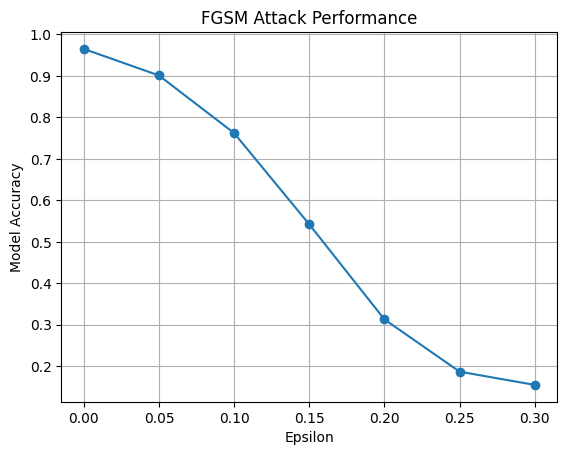

In [12]:
fgsm_accuracy = []
fgsm_perturbed_images = []
fgsm_clean_labels = []
fgsm_perturbed_labels = []
#Provided epsilons set, you can modify it to your own set.#
epsilons = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
for eps in epsilons:
    correct = 0
    labels, perturbed_images, perturbed_labels = fgsm_attack(model, test_loader, eps)
    for i in range(len(perturbed_images)):
        if perturbed_labels[i] == labels[i]:
            correct += 1
    accuracy = correct / len(test_loader)
    print(f"Epsilon: {eps},Test Accuracy: {accuracy}")

    fgsm_accuracy.append(accuracy)
    fgsm_clean_labels.append(labels)
    fgsm_perturbed_images.append(perturbed_images)
    fgsm_perturbed_labels.append(perturbed_labels)

#Plot the relationship between the model accuracy (fgsm_accuracy) and different epsilon (epsilon)#

# ===============================================
# Start code here #
def plot_accuracy_eps(epsilons, accuracies):
  plt.plot(epsilons, accuracies, marker='o')
  plt.xlabel('Epsilon')
  plt.ylabel('Model Accuracy')
  plt.title('FGSM Attack Performance')
  plt.grid(True)
  plt.show()
# End code here #
# ===============================================
plot_accuracy_eps(epsilons,fgsm_accuracy)

Implement visualization to show 5 samples for each $ϵ$ as well as indicating purtabled labels and groundtruth labels.

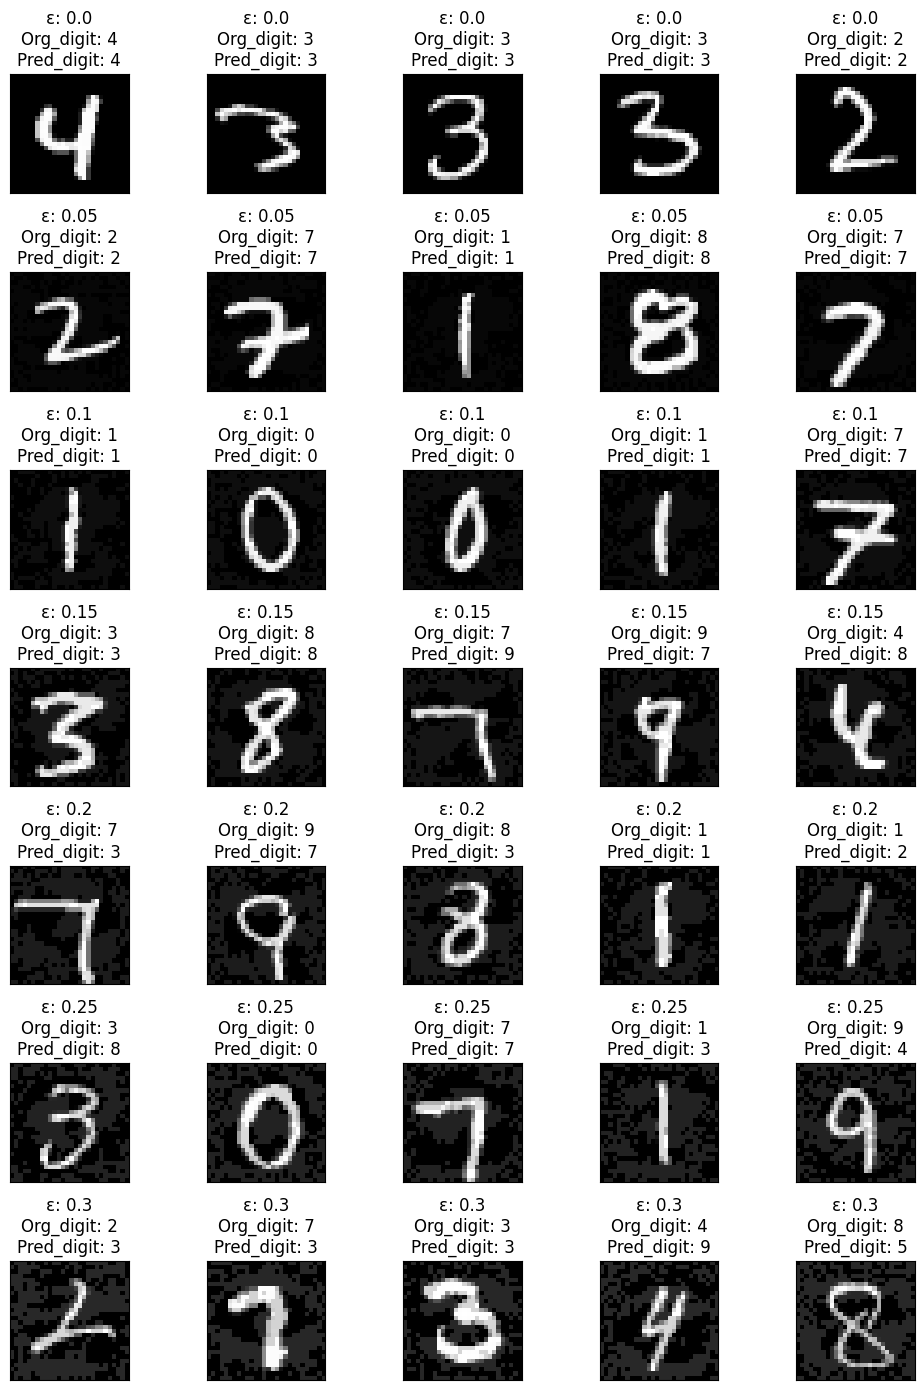

In [19]:
# Visualize 5 examples of the adversarial samples for each epsilon as well as indicating purtabled labels and groundtruth labels
# ===============================================
# Start code here #
def plot_perturbed_examples(epsilons, original_labels, perturbed_labels, perturbed_images):
    n = len(epsilons)
    Samples = 5  # Display 5 samples for each epsilon

    f, a = plt.subplots(n, Samples, figsize=(10, 2 * n))
    for i, eps in enumerate(epsilons):
        for j in range(Samples):
          if (n > 1):
            b = a[i, j]
          else:
            b = a[j]
          im = perturbed_images[i][j].reshape(28, 28)  # Reshape the image to 28 * 28
          b.imshow(im, cmap='gray')
          b.set_title(f"ε: {eps}\nOrg_digit: {original_labels[i][j]}\nPred_digit: {perturbed_labels[i][j]}")
          b.set_xticks([])
          b.set_yticks([])

    plt.tight_layout()
    plt.show()
# End code here #
# ===============================================
plot_perturbed_examples(epsilons, fgsm_clean_labels, fgsm_perturbed_labels, fgsm_perturbed_images)

Implement the PGD (Projected Gradient Descent) attack:

$$x_{t+1}=\Pi_{x+\mathcal{S}}\left(x^t+\alpha \operatorname{sign}\left(\nabla_x L(\theta, x, y)\right)\right)$$

, where $\Pi$ denote the projection operation, $y$ is the label. The projection operation ensures that if an updated input exceeds the constraint region, it is "projected" back into the allowable range.

Here, we take clipping images with $ϵ$ L-inf distance as $\Pi$, the pipeline of PGD attack is:


1.   Begin with $t=0$ ($x_0$ is the clean sample)
2.   Add perturbation: $x_{t+1}=x_t+\alpha \cdot \operatorname{sign}(\nabla_{x_t} L(\theta, x_t, y))$
3.   Project perturbed sample within the constraint region: $x_{t+1}=\operatorname{clip}\left(x_{t+1}, x_0-\epsilon, x_0
+\epsilon\right)$
4.   Repeat $T$ iterations and end.

For 5 arguments of the pgd_perturb function to be implemented:


*   model: the loaded pretrained model for MNIST
*   image: the clean image to be attacked
*   label: the ground truth label for this image
*   epsilon: $ϵ$ mentioned in above step 3 denotes magnitude of constraint  region
*   alpha: $α$ mentioned in above step 2 denotes perturbation step size for PGD
*   iterations: $T$ the number of the iterations for PGD
*   Generate perturbed adversarial image using PGD attack algorithm.



In [48]:
# ===============================================
# Start code here #
def pgd_perturb(model, image, label, epsilon, alpha, iterations):
    # iteration number #
    image = image.to(device)
    original_image = image
    # iteration number #
    for i in range (iterations):
        image.requires_grad = True
        # feed the image to the model for output logit #
        output = model(image)
        model.zero_grad()
        # define the objective function for classfication (CrossEntropyLoss from torch.nn)#
        criterion = nn.CrossEntropyLoss()
        # compute loss using defined criterion #
        loss = criterion(output, label)
        loss.backward()
        # get the signed gradient towards image data #
        sign_data_grad = image.grad.data.sign()
        # implement equation in step 2 to add perturbation at each iteration #
        perturbed_image = image + (alpha * sign_data_grad)
        perturbed_image = torch.clip(perturbed_image, original_image - epsilon, original_image + epsilon)
        # implement equation in step 3 to project perturbed sample within the constraint region #
        image = perturbed_image.detach().view(1, -1)
    return image
# End code here #
# ===============================================

Conduct the PGD (Projected Gradient Descent) attack to the targeted dataset and model.

The 5 arguments for pgd_perturb function: model, test_loader, epsilon, alpha, iterations denote targeted model, test MNIST dataloader, $\epsilon$, $\alpha$, and iteration number.

We need the output perturbed_images (perturbed images set), labels (clean images' prediction), perturbed_labels (perturbed images' prediction)

*   Do model inference on clean images to get clean predictions
*   Get PGD perturbed images using defined pgd_perturb function.
*   Do model inference on perturbed images to get prediction result after attack.

In [55]:
# ===============================================
# Start code here #
def pgd_attack(model, test_loader, epsilon, alpha, iterations):
    model.eval()
    # Create empty lists for perturbed_images (perturbed images set), labels (clean images' prediction set), perturbed_labels (perturbed images' prediction set)#
    labels = []
    perturbed_images = []
    perturbed_labels = []
    # get image and corresponding label iteratively and put image into GPU device. We set the batchsize = 1, so each iteration will give 1 sample #
    for image,label in test_loader:
        image = image.to(device).view(1,-1)
        label = label.to(device)
        # Call pgd_perturb to add perturbation to the data
        perturbed_image = pgd_perturb(model, image, label, epsilon, alpha, iterations)
        # feed the perturbed image to the model for output logit #
        perturbed_output = model(perturbed_image)
        # get the predicted label #
        perturbed_label= torch.argmax(perturbed_output.data, 1)


        labels.append(label.item())
        perturbed_images.append(perturbed_image.detach().cpu().numpy())
        perturbed_labels.append(perturbed_label.item())

    # Return the clean labels, perturbed images and perturbed images' labels
    return labels, perturbed_images, perturbed_labels
# End code here #
# ===============================================

Try your implementation with different $ϵ$ or $α$ or iteration number. Sample $ϵ$, $α$ and iteration number are provided.

Using the following cell to call your implementation to check attack performance with different $ϵ$ (or your selected argument between $ϵ$, $α$ and interation number).

Using or modifying implemented plot function above to plot the relationship between the model accuracy (PGD_accuracy) and different $ϵ$ or α or iteration number.

Epsilon: 0.0,Test Accuracy: 0.965
Epsilon: 0.05,Test Accuracy: 0.899
Epsilon: 0.1,Test Accuracy: 0.745
Epsilon: 0.15,Test Accuracy: 0.485
Epsilon: 0.2,Test Accuracy: 0.251
Epsilon: 0.25,Test Accuracy: 0.154
Epsilon: 0.3,Test Accuracy: 0.154


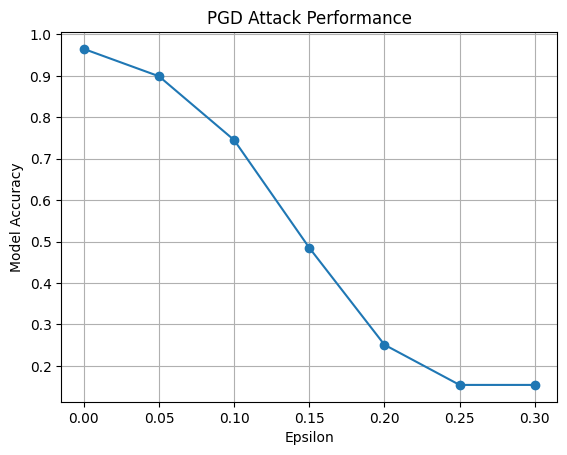

In [57]:
# Run the PGD attack
pgd_accuracy = []
pgd_perturbed_images = []
pgd_clean_labels = []
pgd_perturbed_labels = []
# provided sample on different epsilon, try your setting
epsilons = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
alpha = 0.03
iterations = 8

for eps in epsilons:
    correct = 0
    labels, perturbed_images, perturbed_labels = pgd_attack(model, test_loader, eps, alpha, iterations)
    for i in range(len(perturbed_images)):
        if perturbed_labels[i] == labels[i]:
            correct += 1
    accuracy = correct / len(test_loader)
    print(f"Epsilon: {eps},Test Accuracy: {accuracy}")

    pgd_accuracy.append(accuracy)
    pgd_perturbed_images.append(perturbed_images)
    pgd_clean_labels.append(labels)
    pgd_perturbed_labels.append(perturbed_labels)

#Plot the relationship between the model accuracy (pgd_accuracy) and between your selected arguments#
#Using or modifying implemented plot function in Task 6#
def plot_accuracy_eps(epsilons, accuracies):
  plt.plot(epsilons, accuracies, marker='o')
  plt.xlabel('Epsilon')
  plt.ylabel('Model Accuracy')
  plt.title('PGD Attack Performance')
  plt.grid(True)
  plt.show()

plot_accuracy_eps(epsilons, pgd_accuracy)

Use implemented plot function above for visualization to show 5 samples for each $ϵ$ (or your selected argument between $ϵ$, $α$ and interation number) as well as indicating purtabled labels and groundtruth labels.

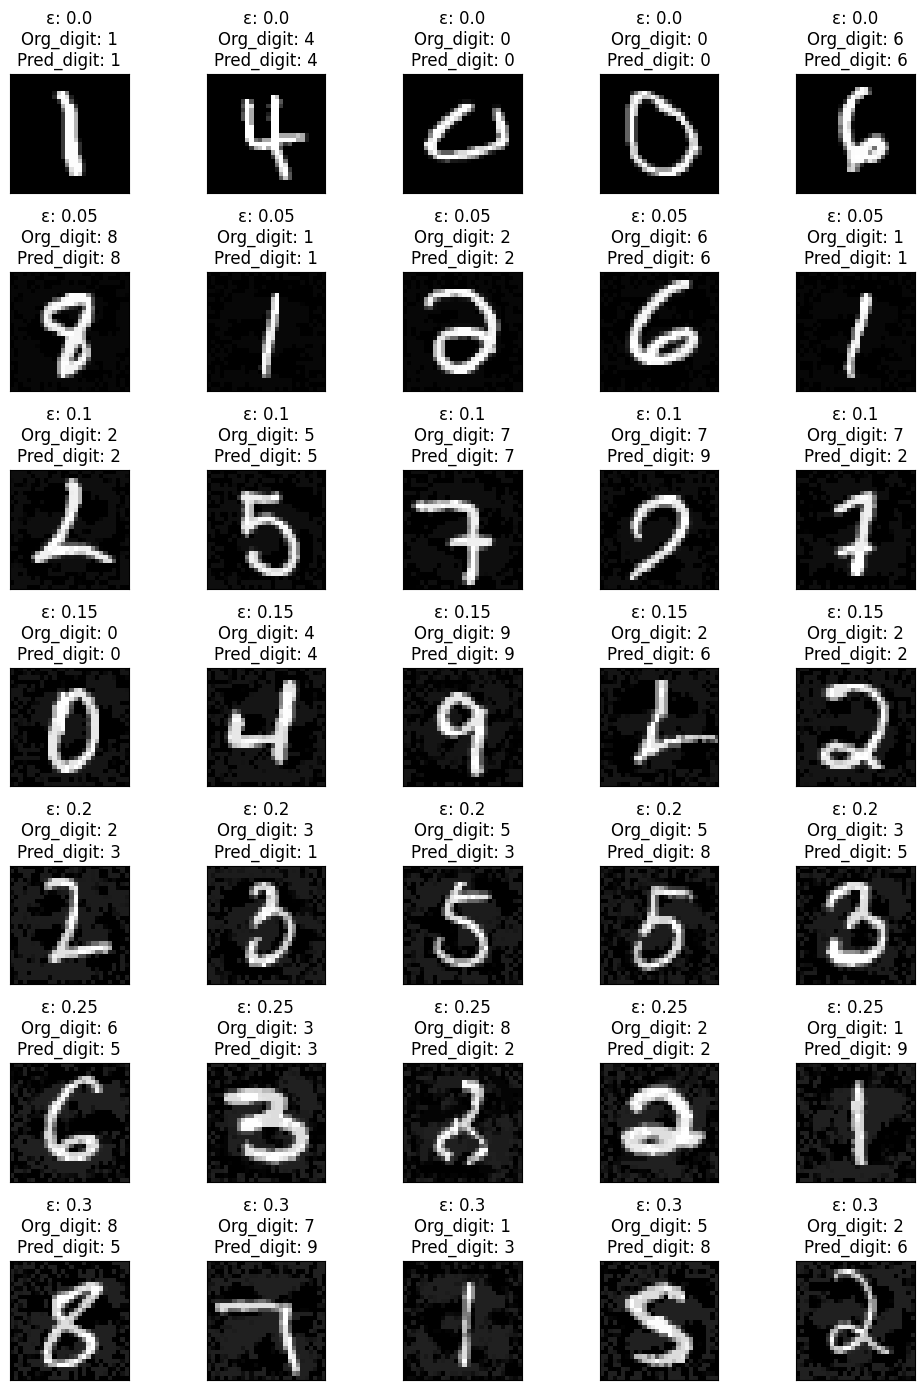

In [60]:
# Visualize 5 examples of the adversarial samples for each epsilon (or your selected argument) as well as indicating purtabled labels and groundtruth labels
# ===============================================
# Start code here #
def plot_perturbed_examples(epsilons, original_labels, perturbed_labels, perturbed_images):
    n = len(epsilons)
    Samples = 5  # Display 5 samples for each epsilon

    f, a = plt.subplots(n, Samples, figsize=(10, 2 * n))
    for i, eps in enumerate(epsilons):
        for j in range(Samples):
          if (n > 1):
            b = a[i, j]
          else:
            b = a[j]
          im = perturbed_images[i][j].reshape(28, 28)  # Reshape the image to 28 * 28
          b.imshow(im, cmap='gray')
          b.set_title(f"ε: {eps}\nOrg_digit: {original_labels[i][j]}\nPred_digit: {perturbed_labels[i][j]}")
          b.set_xticks([])
          b.set_yticks([])

    plt.tight_layout()
    plt.show()
# End code here #
# ===============================================
plot_perturbed_examples(epsilons , pgd_clean_labels, pgd_perturbed_labels, pgd_perturbed_images)